In [1]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
data = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin1')
data = data.loc[:, ['v1', 'v2']]
data = data.rename(columns={'v1': 'label', 'v2': 'message'})
data['label'].replace({'ham': 1, 'spam': 0}, inplace=True)

/tmp/ipykernel_18/3492939006.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['label'].replace({'ham': 1, 'spam': 0}, inplace=True)
/tmp/ipykernel_18/3492939006.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'].replace({'ham': 1, 'spam': 0}, inplace=True)


<Axes: xlabel='label', ylabel='count'>

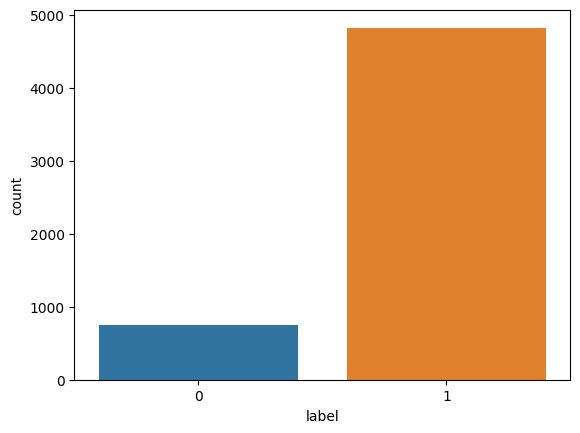

In [3]:
import seaborn as sns 
sns.countplot(x=data['label'])

In [4]:
import re
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

### Clean messages

methods:
- Stemmer: stem
- WordNetLemmatizer: lemmatize
- WordNetLemmatizer with POS: lemmatize_pos

In [5]:
# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_message(message, method):
    
    def semmatize_msg():
        return [stemmer.stem(word) for word in tokens]
    
    def lemmatize_msg():
        return [lemmatizer.lemmatize(word) for word in tokens]
    
    def lemmatize_pos_msg():
        pos_tags = nltk.pos_tag(tokens)
        return [
            lemmatizer.lemmatize(word, pos='v' if tag.startswith('V') else 'n' if tag.startswith('N') else 'a' if tag.startswith('J') else 'r' if tag.startswith('R') else 'n')
            for word, tag in pos_tags
        ]
    
    # Lowercase the message
    message = message.lower()
    
    # Remove everything except letters
    message = re.sub(r'[^a-z\s]', '', message)
    
    # Tokenize the message
    tokens = nltk.word_tokenize(message)
    
    # Remove single character words and stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if len(word) > 1 and word not in stop_words]
    
    # Apply the selected method for word processing
    if method == 'stem':
        processed_tokens = semmatize_msg()
    elif method == 'lemmatize':
        processed_tokens = lemmatize_msg()
    elif method == 'lemmatize_pos':
        processed_tokens = lemmatize_pos_msg()
    else:
        raise ValueError("Invalid method. Choose from 'stem', 'lemmatize', or 'lemmatize_pos'.")
    
    # Join the tokens back into a single string
    cleaned_message = ' '.join(processed_tokens)

    return cleaned_message

In [6]:
# Function to apply cleaning on a DataFrame column
def clean_messages_column(df, column_name, method='lemmatize'):
    # Apply the cleaning function on the specified column
    df[column_name] = df[column_name].apply(lambda x: clean_message(x, method))
    
    # Create the corpus as a list
    corpus = df[column_name].tolist()
    return corpus

### Create Word Vector

- bow
- tf-idf
- Embedding

In [7]:
def word_vector(corpus, vector_method='bow'):
    if vector_method == 'bow':
        vectorizer = CountVectorizer()
    elif vector_method == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Invalid vector method. Choose from 'bow' or 'tfidf'.")
    
    X = vectorizer.fit_transform(corpus)
    y = data['label']  # Assuming your DataFrame has a column 'label' for classification

    return X, y

In [8]:
def prediction(method = 'stem', vector_method='bow'):
    
    ## Prepare Data 
    corpus = clean_messages_column(data, 'message', method=method)
    X, y = word_vector(corpus, vector_method=vector_method)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
    
    ## Train
    cls = MultinomialNB()
    cls.fit(X_train, y_train)
    
    ## Test
    y_pred = cls.predict(X_test)
    
    ## Evaluate
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"Confusion Matrix for predicting Spam Emails using {method} and {vector_method}: \n{cm}\nAccuracy: {acc} \nPrecision: {pre} \nRecall: {rec} \n")
    return {'method': method, 'vector_method': vector_method, 'accuracy': acc, 'precision': pre, 'recall': rec}


In [9]:
def compare_methods():
    methods = ['stem', 'lemmatize', 'lemmatize_pos']
    vector_methods = ['bow', 'tfidf']
    results = []

    # Run prediction for each method and store results
    for method in methods:
        for vector_method in vector_methods:
            result = prediction(method=method, vector_method=vector_method)
            results.append(result)


    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    print("\nComparison Report:")
    print(results_df)

    return results_df

In [10]:
report = compare_methods()

Confusion Matrix for predicting Spam Emails using stem and bow: 
[[ 221   17]
 [  35 1399]]
Accuracy: 0.9688995215311005 
Precision: 0.9879943502824858 
Recall: 0.9755927475592747 

Confusion Matrix for predicting Spam Emails using stem and tfidf: 
[[ 162   76]
 [   0 1434]]
Accuracy: 0.9545454545454546 
Precision: 0.9496688741721855 
Recall: 1.0 

Confusion Matrix for predicting Spam Emails using lemmatize and bow: 
[[ 221   17]
 [  35 1399]]
Accuracy: 0.9688995215311005 
Precision: 0.9879943502824858 
Recall: 0.9755927475592747 

Confusion Matrix for predicting Spam Emails using lemmatize and tfidf: 
[[ 162   76]
 [   0 1434]]
Accuracy: 0.9545454545454546 
Precision: 0.9496688741721855 
Recall: 1.0 

Confusion Matrix for predicting Spam Emails using lemmatize_pos and bow: 
[[ 220   18]
 [  33 1401]]
Accuracy: 0.9694976076555024 
Precision: 0.9873150105708245 
Recall: 0.9769874476987448 

Confusion Matrix for predicting Spam Emails using lemmatize_pos and tfidf: 
[[ 162   76]
 [   0 1

In [11]:
report.sort_values(by="accuracy", ascending=False)

,method,vector_method,accuracy,precision,recall
4,lemmatize_pos,bow,0.969498,0.987315,0.976987
0,stem,bow,0.968900,0.987994,0.975593
2,lemmatize,bow,0.968900,0.987994,0.975593
1,stem,tfidf,0.954545,0.949669,1.000000
3,lemmatize,tfidf,0.954545,0.949669,1.000000
5,lemmatize_pos,tfidf,0.954545,0.949669,1.000000
